In [485]:
import numpy as np
# import sklearn as kl

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

from itertools import cycle
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')

In [486]:
# generate fake data
def sigmoid(x, mu, m, c, g=1):
    return c + m / (1 + np.exp(-(x-mu)/g))

def norm(a):
    return (a - np.nanmin(a)) / np.nanmax((a - np.nanmin(a)))

In [487]:
np.random.seed(4)
x = np.arange(300)
Ba = np.random.normal(4E-6, 1E-7, 300)
Al = sigmoid(x, 150, 6E-4, 30E-5, 6) + np.random.normal(0, 4E-5, 300)
Mg = (np.sin(x/20) + 1) / 2000 + np.random.normal(1E-3, 2E-4, 300)

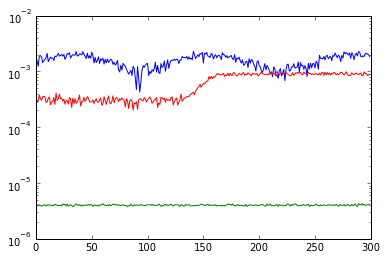

In [443]:
plt.plot(Mg)
plt.plot(Ba)
plt.plot(Al)
plt.yscale('log')

In [444]:
d = np.vstack((Ba, Al, Mg)).T

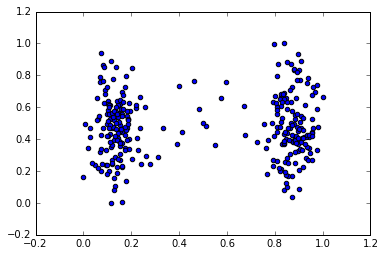

In [445]:
plt.scatter(norm(Al), norm(Ba))

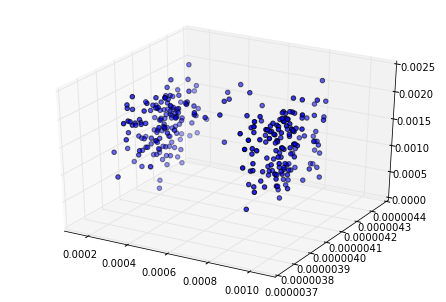

In [446]:
fig = plt.figure()
ax = Axes3D(fig)

# ax.scatter(norm(Al), norm(Ba), norm(Mg))
ax.scatter(Al,Ba,Mg)

In [447]:
d = np.vstack((Ba, Al)).T
dn = norm(d)

# Clustering Algorythms

That don't need prior knowledge of number of clusters

## Affinity Propagation
needs 'damping' and 'sample preference'

In [448]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

In [449]:
af = AffinityPropagation(damping=0.8).fit(d)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

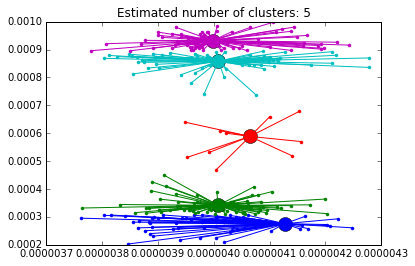

In [450]:
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = d[cluster_centers_indices[k]]
    plt.plot(d[class_members, 0], d[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in d[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)

Significantly over-estimates clusters.

## MeanShift Clustering
Needs 'bandwidth' of clusters

In [451]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# d = norm(d)  # insensitive to normalisation

In [452]:
# NUMBER OF CLUSTERS VERY SENSITIVE TO BANDWIDTH SELECTION!
bandwidth = estimate_bandwidth(d, quantile=0.5)
bandwidth

0.00028787124201524984

In [453]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(d)

MeanShift(bandwidth=0.00028787124201524984, bin_seeding=True,
     cluster_all=True, min_bin_freq=1, n_jobs=1, seeds=None)

In [454]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

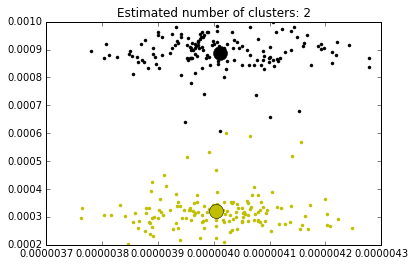

In [455]:
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(d[my_members, 0], d[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)

n_clusters highly sensitive to bandwidth and number of variables

In [456]:
# fig = plt.figure()
# ax = Axes3D(fig)

# for k, col in zip(range(n_clusters_), colors):
#     my_members = labels == k
#     cluster_center = cluster_centers[k]
#     ax.scatter(d[my_members, 1], d[my_members, 0], d[my_members, 2], c=col)
#     ax.scatter(cluster_center[1], cluster_center[0], cluster_center[2], 'o', c=col,
#                s=200)
# ax.set_title('Estimated number of clusters: %d' % n_clusters_)

# ax.set_xlabel('Al')
# ax.set_ylabel('Ba')
# ax.set_zlabel('Mg')


## DBSCAN
Requires estimate of 'neighbourhood size'

- eps: The maximum distance between two samples for them to be considered as in the same neighborhood.
- Data must be normalised

In [465]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [466]:
db = DBSCAN(eps=0.015, min_samples=5).fit(dn)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

/Users/oscarbranson/anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/lines.py:1106: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._markerfacecolor != fc:


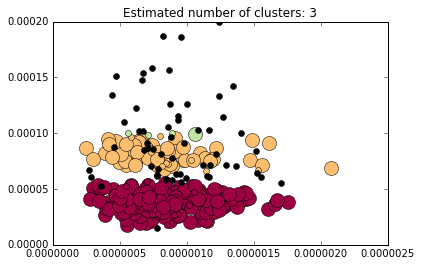

In [467]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = d[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = d[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)

# Try with Real Data

In [500]:
import pickle
dat = pickle.load( open( "sam.pkl", "rb" ) )

In [501]:
d = []
cols = []
for k,v in dat.items():
    if ('Ca' not in k) & ('Mg' not in k) & ('Sr' not in k):
        d.append(v[~np.isnan(v)])
        cols.append(k)
d = np.vstack(d).T
d = d[d[:,1] < 200E-6,:]
dn = norm(d)

In [502]:
list(zip(np.arange(len(cols)),cols, np.apply_along_axis(np.nanstd,0,dn)))

[(0, 'Ba137', 0.0015133570284554096),
 (1, 'Al27', 0.14709916677495571),
 (2, 'Mn55', 0.025071009905063026),
 (3, 'Ba138', 0.0008981037912683008)]

### Affinity Propagation

In [507]:
af = AffinityPropagation(damping=0.9).fit(d)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

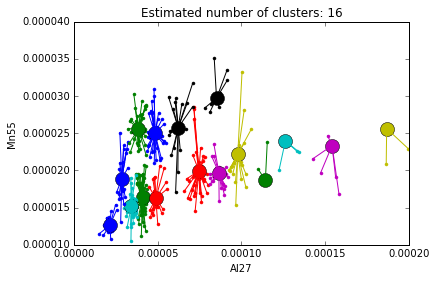

In [508]:
xv = 1
yv = 2

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = d[cluster_centers_indices[k]]
    plt.plot(d[class_members, xv], d[class_members, yv], col + '.')
    plt.plot(cluster_center[xv], cluster_center[yv], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in d[class_members]:
        plt.plot([cluster_center[xv], x[xv]], [cluster_center[yv], x[yv]], col)

plt.xlabel(cols[xv])
plt.ylabel(cols[yv])

plt.title('Estimated number of clusters: %d' % n_clusters_)

### MeanShift Clustering

In [524]:
bandwidth = estimate_bandwidth(dn, quantile=0.3)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(dn)

MeanShift(bandwidth=0.091585016325907029, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, n_jobs=1, seeds=None)

In [525]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

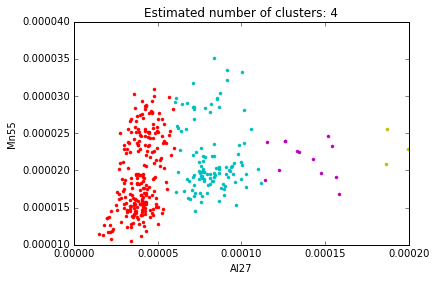

In [526]:
xv = 1
yv = 2

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(d[my_members, xv], d[my_members, yv], col + '.')
#     plt.plot(cluster_center[xv], cluster_center[yv], 'o', markerfacecolor=col,
#              markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)

plt.xlabel(cols[xv])
plt.ylabel(cols[yv])

### DBSCAN

In [534]:
db = DBSCAN(eps=0.02, min_samples=5).fit(dn)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

/Users/oscarbranson/anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/lines.py:1106: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._markerfacecolor != fc:


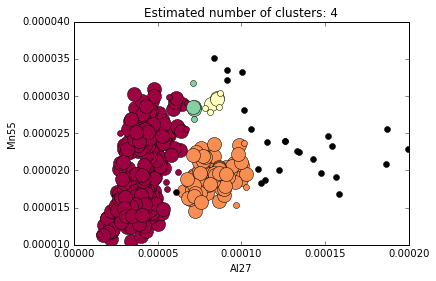

In [535]:
xv = 1
yv = 2

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = d[class_member_mask & core_samples_mask]
    plt.plot(xy[:, xv], xy[:, yv], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = d[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, xv], xy[:, yv], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)

plt.xlabel(cols[xv])
plt.ylabel(cols[yv])